In [1]:
import dask.distributed
import folium
import folium.plugins
import geopandas as gpd
import shapely.geometry
from IPython.display import display
from pystac_client import Client

from odc.stac import configure_rio, stac_load


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

/home/cy0/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
display(client)

/home/cy0/.local/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37823 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37823/status,
Dashboard: http://127.0.0.1:37823/status,Workers: 4
Total threads: 4,Total memory: 11.38 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41411,Workers: 4
Dashboard: http://127.0.0.1:37823/status,Total threads: 4
Started: Just now,Total memory: 11.38 GiB
Comm: tcp://127.0.0.1:36571,Total threads: 1
Dashboard: http://127.0.0.1:44375/status,Memory: 2.85 GiB
Nanny: tcp://127.0.0.1:46647,


In [3]:
km2deg = 1.0 / 111
x, y = (113.887, -25.843)  # Center point of a query
r = 100 * km2deg
bbox = (x - r, y - r, x + r, y + r)

catalog = Client.open("https://earth-search.aws.element84.com/v1/")

query = catalog.search(
    collections=["sentinel-2-l2a"], datetime="2021-09-16", limit=100, bbox=bbox
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.item_collection_as_dict()

Found: 18 datasets


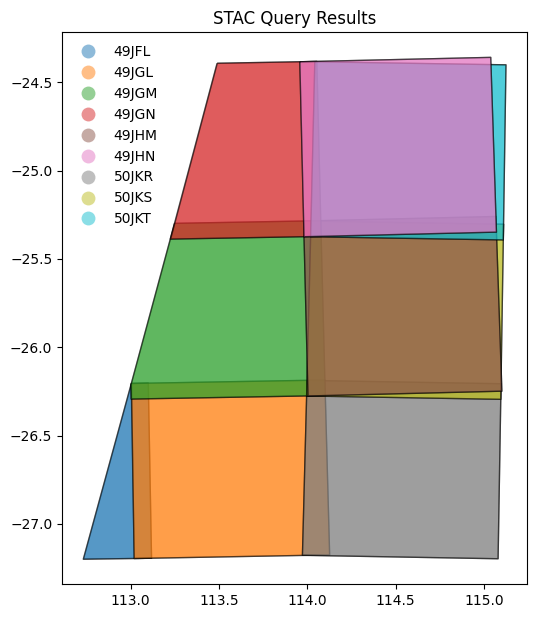

In [4]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

# Compute granule id from components
gdf["granule"] = (
    gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["mgrs:latitude_band"]
    + gdf["mgrs:grid_square"]
)

fig = gdf.plot(
    "granule",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

In [5]:
# https://github.com/python-visualization/folium/issues/1501
from branca.element import Figure

fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)

gdf.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
display(fig)

/tmp/ipykernel_57528/1652784297.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))


In [8]:
# Since we will plot it on a map we need to use `EPSG:3857` projection
crs = "epsg:3857"
zoom = 2**5  # overview level 5

xx = stac_load(
    items,
    bands=("red", "green", "blue","coastal","rededge1","rededge2","rededge3","nir","nir08","nir09","swir16","swir22"),
    crs=crs,
    resolution=10 * zoom,
    chunks={},  # <-- use Dask
    groupby="solar_day",
)
display(xx)

<xarray.Dataset> Size: 29MB
Dimensions:      (y: 1101, x: 1087, time: 1)
Coordinates:
  * y            (y) float64 9kB -2.797e+06 -2.798e+06 ... -3.149e+06 -3.149e+06
  * x            (x) float64 9kB 1.247e+07 1.247e+07 ... 1.282e+07 1.282e+07
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 8B 2021-09-16T02:34:44.451000
Data variables:
    red          (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    green        (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    blue         (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    coastal      (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    rededge1     (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    rededge2     (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    rededge3     (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    nir          (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    nir08        (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    nir09        (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    swir16       (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    swir22       (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>

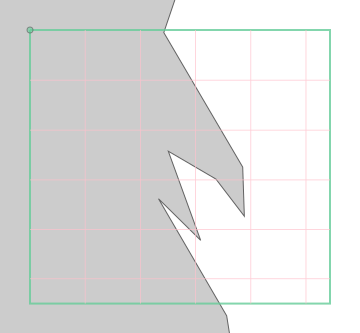

In [9]:
xx.odc.geobox

In [10]:
%%time
xx = xx.compute()

/home/cy0/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/cy0/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/cy0/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 

CPU times: user 8.24 s, sys: 2.11 s, total: 10.4 s
Wall time: 1min 32s


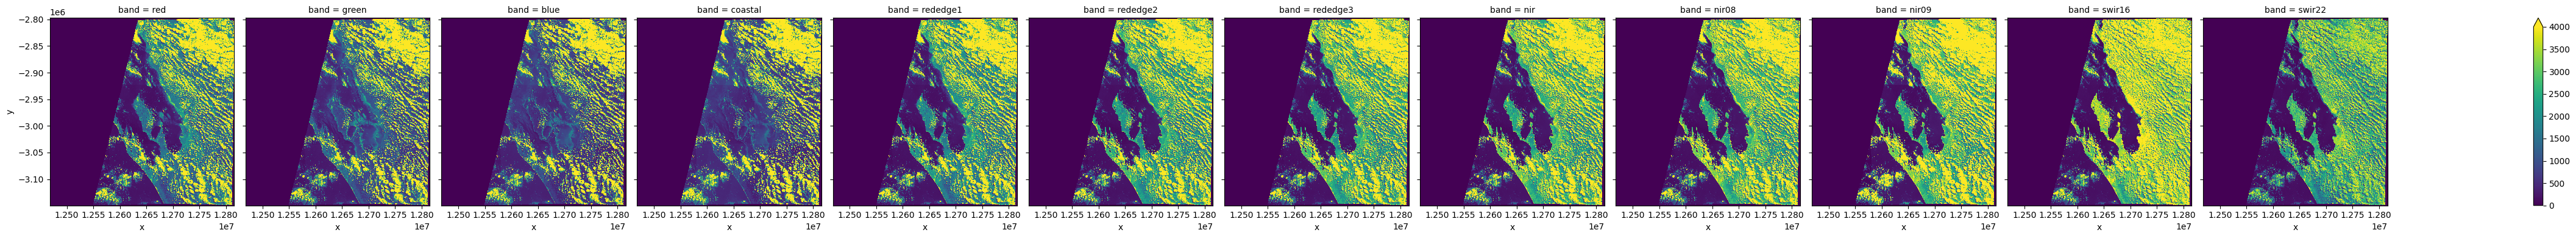

In [11]:
_ = (
    xx.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)

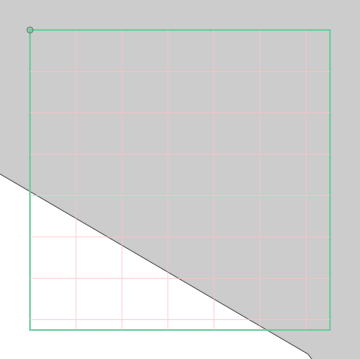

In [12]:
r = 6.5 * km2deg
small_bbox = (x - r, y - r, x + r, y + r)

yy = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10,
    chunks={},  # <-- use Dask
    groupby="solar_day",
    bbox=small_bbox,
)
display(yy.odc.geobox)

In [13]:
yy = yy.compute()

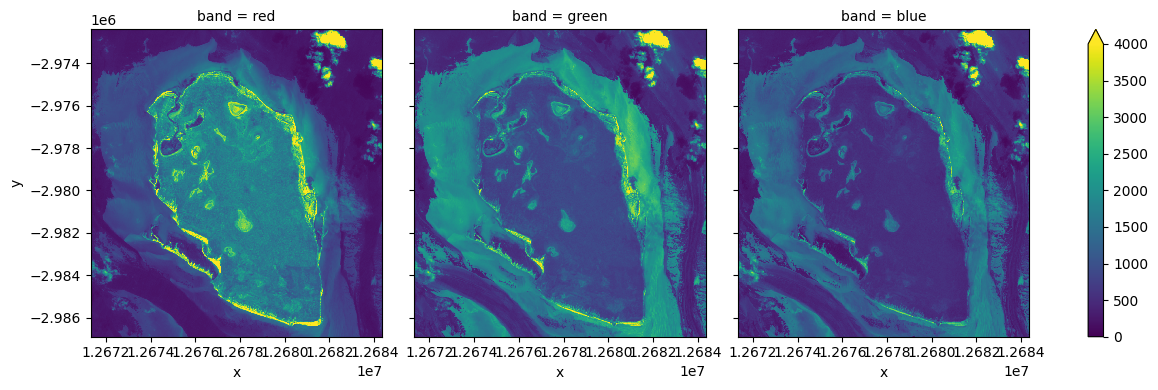

In [14]:
_ = (
    yy.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)